In [1]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from localization import datasets
from localization import models
from localization import samplers
from localization.experiments.batched_online import simulate, make_key

from utils import ipr, entropy, entropy_sort, mean_sort, var_sort, plot_receptive_fields, plot_rf_evolution

def simulate_or_load(**kwargs):
    path_key = make_key(**kwargs)
    if path_key + '.npz' in os.listdir('../localization/results/weights'):
        print('Already simulated')
        data = np.load('../localization/results/weights/' + path_key + '.npz', allow_pickle=True)
        weights_, metrics_ = data['weights'], data['metrics']
    else:
        print('Simulating')
        weights_, metrics_ = simulate(**kwargs)
    return weights_, metrics_

def build_gaussian_covariance(L, xi):
    C = np.abs(jnp.tile(jnp.arange(L)[:, jnp.newaxis], (1, L)) - jnp.tile(jnp.arange(L), (L, 1)))
    C = jnp.minimum(C, L - C)
    C = np.exp(-C ** 2 / (xi ** 2))
    return C

config_ = dict(
    # data config
    num_dimensions=40, xi1=2, xi2=1,
    # num_dimensions=100, xi1=6, xi2=3,
    batch_size=1000,
    support=(-1, 1), # defunct
    class_proportion=0.5,
    # model config
    model_cls=models.SimpleNet,
    num_hiddens=40,
    # num_hiddens=100,
    activation='sigmoid',
    use_bias=True,
    sampler_cls=samplers.EpochSampler,
    init_fn=models.xavier_normal_init,
    init_scale=1.,
    # learning config
    num_epochs=5000,
    # num_epochs=20000,
    evaluation_interval=100,
    optimizer_fn=optax.sgd,
    learning_rate=5.,
    # experiment config
    seed=0,
    save_=True,
    wandb_=False,
)

In [2]:
# NLGP
config = config_.copy()
config.update(dict(
    num_hiddens=40, learning_rate=10.0, num_epochs=5000, gain=3,
    batch_size=5000, evaluation_interval=10, 
    dataset_cls=datasets.NonlinearGPDataset,
))

weights_nlgp, metrics_nlgp = simulate_or_load(**config)
# fig, axs = plot_receptive_fields(weights_nlgp[::10], num_cols=11, evaluation_interval=100, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

Already simulated


In [3]:
# Gaussian clone
config = config_.copy()
config.update(dict(
    num_hiddens=40, learning_rate=10.0, num_epochs=5000, gain=3,
    batch_size=5000, evaluation_interval=10, 
    dataset_cls=datasets.NLGPGaussianCloneDataset,
))

weights_gauss, metrics_gauss = simulate_or_load(**config)
# fig, axs = plot_receptive_fields(weights_gauss[::10], num_cols=11, evaluation_interval=100, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

Already simulated


### Comparing losses

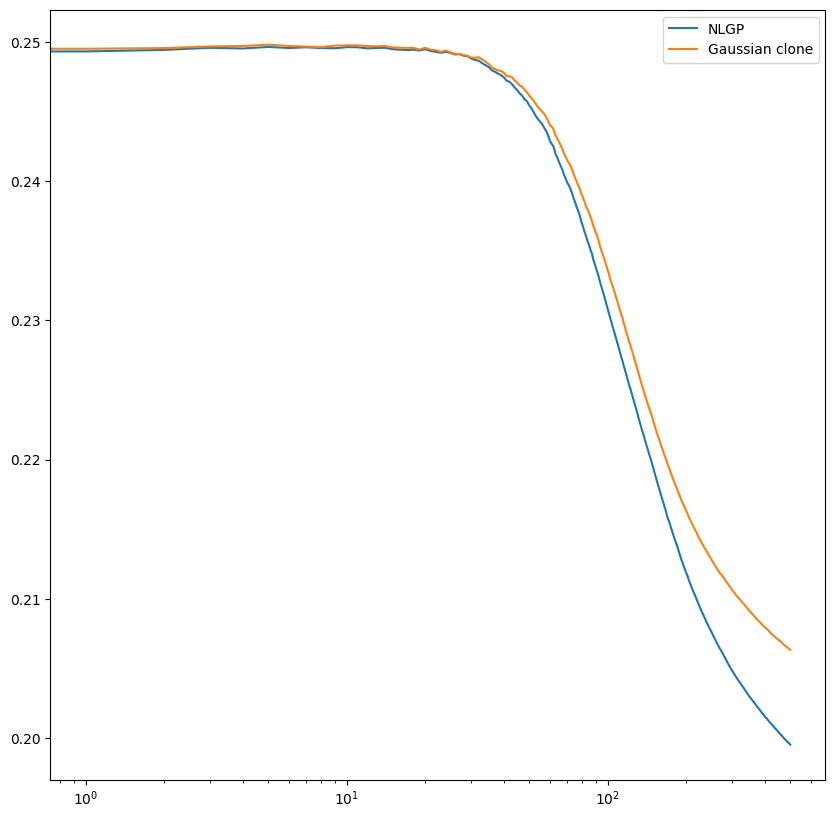

In [4]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(metrics_nlgp[:,1], label='NLGP')
ax.plot(metrics_gauss[:,1], label='Gaussian clone')
# ax.set_xticks(metrics_nlgp[:,0])
ax.set_xscale('log')
ax.legend()

### Comparing weights

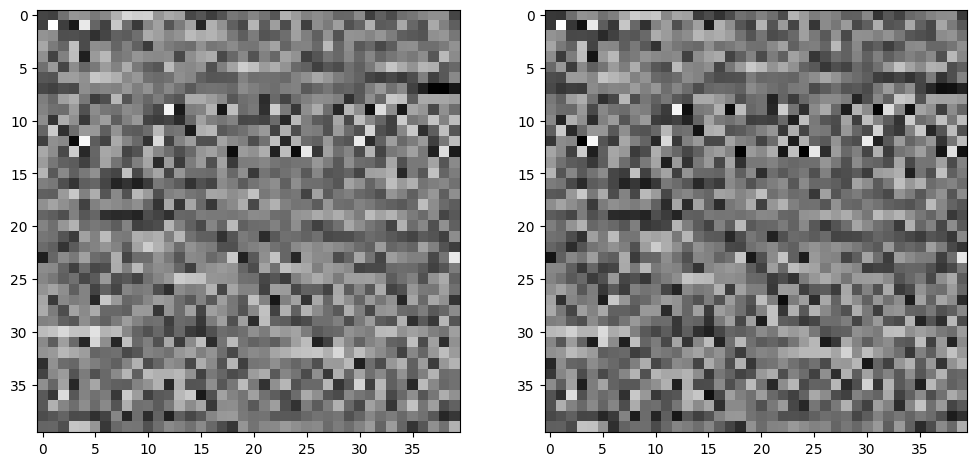

In [5]:
t = 50
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(weights_nlgp[t], cmap='gray')
ax2.imshow(weights_gauss[t], cmap='gray')

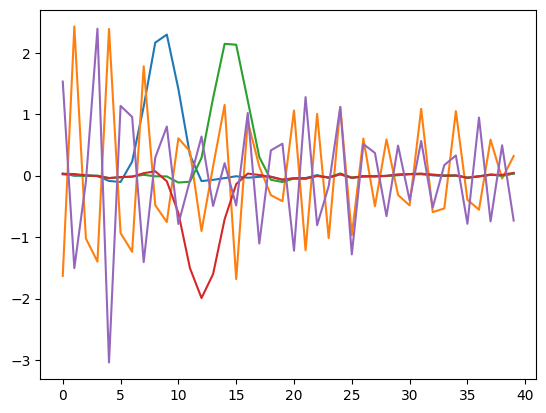

In [6]:
_ = plt.plot( weights_nlgp[-1,:5].T )

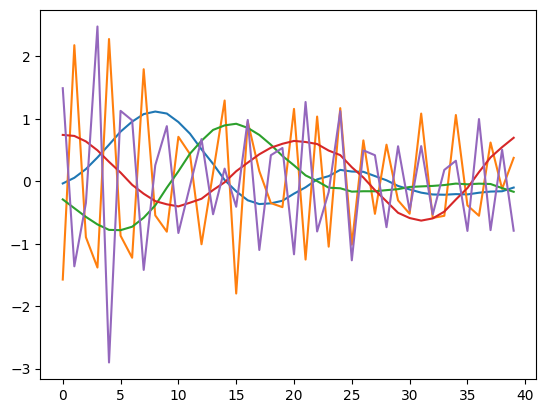

In [7]:
_ = plt.plot( weights_gauss[-1,:5].T )

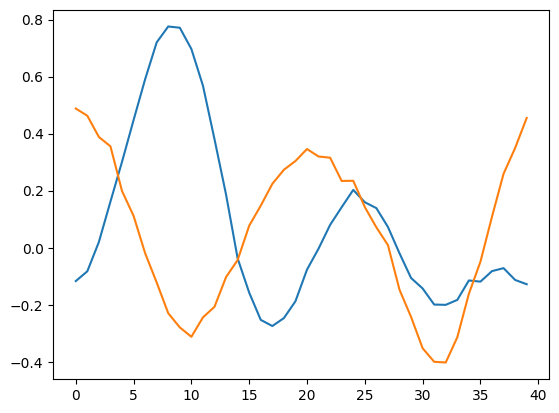

In [64]:
_ = plt.plot( weights_gauss[200,[0,3]].T )

In [9]:
from localization.utils import build_gaussian_covariance, build_non_gaussian_covariance
Sigma1 = build_non_gaussian_covariance(40, 2, 3)
Sigma0 = build_non_gaussian_covariance(40, 1, 3)

In [72]:
x = np.stack([ weights_gauss[t] @ Sigma1 @ weights_gauss[t].T for t in range(len(weights_gauss)) ], axis=0)
# x = np.stack([ weights_nlgp[t] @ Sigma1 @ weights_nlgp[t].T for t in range(len(weights_nlgp)) ], axis=0)
x_ = x[:,[0,3],:][:,:,[0,3]]

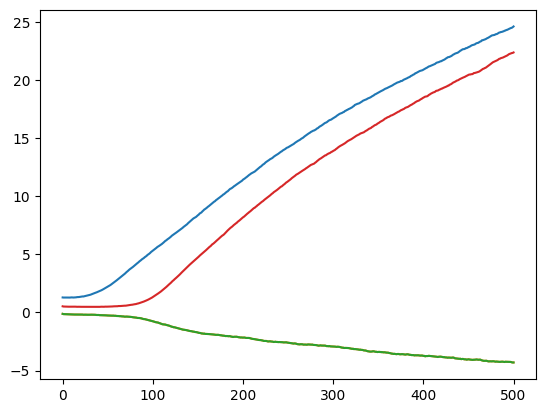

In [73]:
im = plt.plot( x_.reshape(-1, 4) )

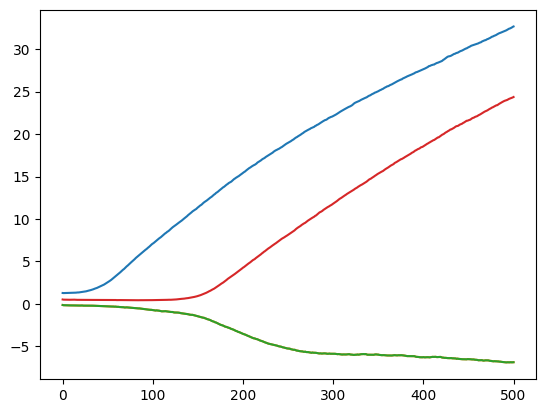

In [71]:
im = plt.plot( x_.reshape(-1, 4) )

In [67]:
x_[-1]

array([[24.629889 , -4.3070045],
       [-4.307004 , 22.39272  ]], dtype=float32)

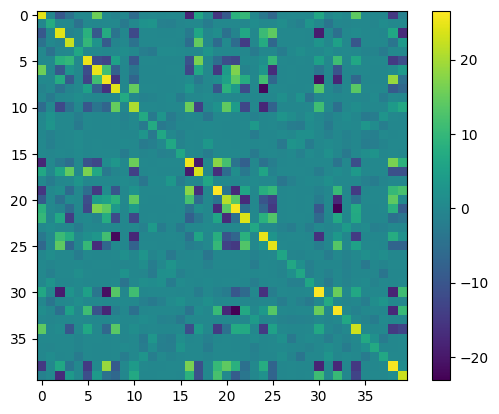

In [75]:
im = plt.imshow( x[-1] )
cbar = plt.colorbar(im)

In [74]:
x[0]

array([[ 1.2932832 , -0.28481066, -0.1817813 , ..., -0.00548422,
        -0.16069667,  0.14972404],
       [-0.28481072,  0.5675186 ,  0.16771972, ...,  0.17157018,
         0.04886456,  0.02542712],
       [-0.18178132,  0.16771977,  0.8567412 , ..., -0.09608778,
         0.04829783, -0.02188977],
       ...,
       [-0.00548427,  0.17157018, -0.0960878 , ...,  0.92073685,
         0.13349913, -0.26792288],
       [-0.16069669,  0.04886461,  0.04829786, ...,  0.13349912,
         1.0602669 , -0.30016136],
       [ 0.14972408,  0.0254271 , -0.02188977, ..., -0.26792285,
        -0.3001614 ,  0.919406  ]], dtype=float32)

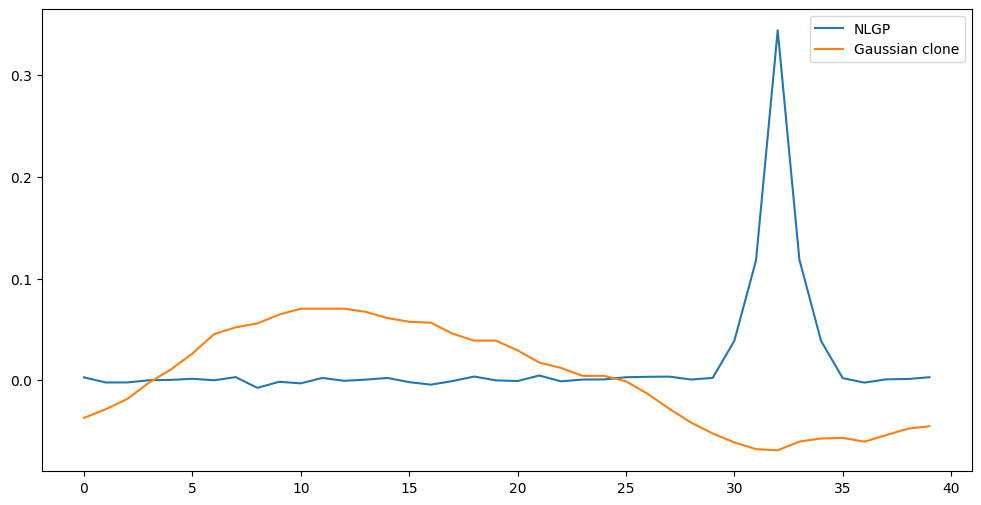

In [13]:
t = -1 # 63 # 23 # 33
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot( weights_nlgp[t].flatten(), label='NLGP')
ax.plot( weights_gauss[t].flatten(), label='Gaussian clone')
ax.legend()

The NLGP and Gaussian clone are identical during the first 25 evaluation (=250 gradient steps, or 6.25 units of training time), in terms of both prediction loss and their weights.

After this point, we see separation in both.
The loss plateaus for the Gaussian clone, while it drops suddenly and then levels off the NLGP data.
At this point, the weights begin to diverge as well.
During the early period, both weights shrink (somewhat uniformly) towards zero.
But, for some reason, after 25 steps, the weights begin to diverge.
For the NLGP model, it's receptive field increasingly becomes peaked around its maximum.
Meanwhile, for the Gaussian clone, we see it begin to stretch out towards a long-range oscillation.
I wonder if the point at which this transition occurs is a consequence of the regularization term in the Gaussian ODE beginning to dominate.
(It doesn't really look like it though, and I'd be surprised if it were so easy, since the NLGP model almost certainly has a different regularization term.)

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

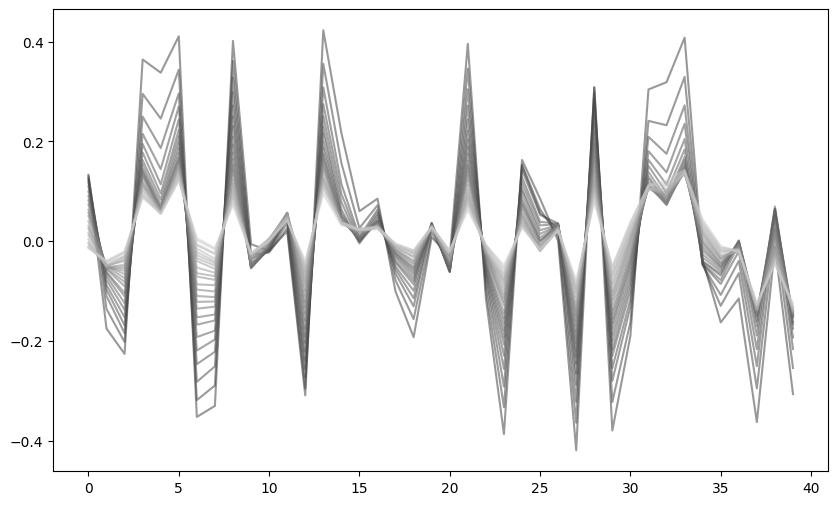

In [25]:
plot_rf_evolution(weights_nlgp[:25], num_cols=1, num_rows=1, figsize=(10, 6))

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

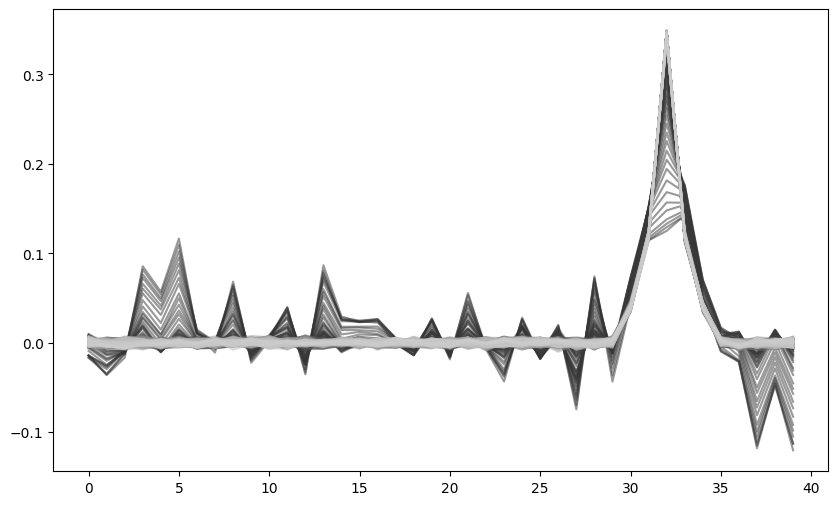

In [24]:
plot_rf_evolution(weights_nlgp[25:], num_cols=1, num_rows=1, figsize=(10, 6))

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

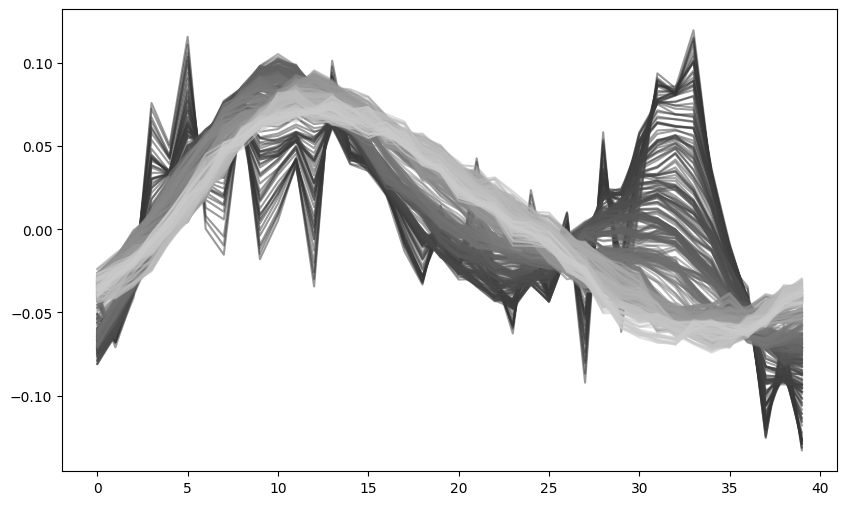

In [23]:
plot_rf_evolution(weights_gauss[25:], num_cols=1, num_rows=1, figsize=(10, 6))

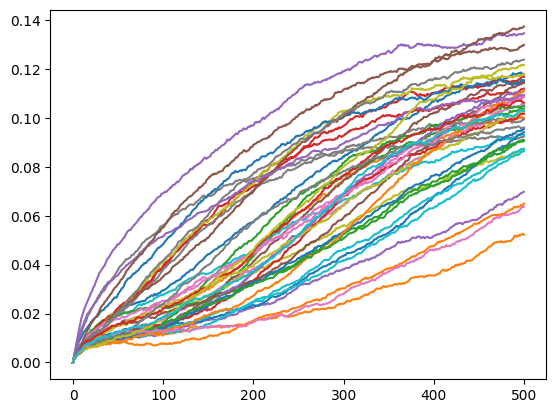

In [238]:
err = np.sqrt(np.mean(np.square(weights_nlgp - weights_gauss), axis=(2,)))
_ = plt.plot( err )

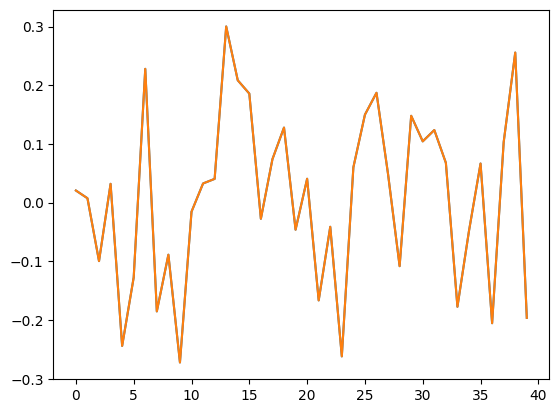

In [239]:
t = 0 # 100
_ = plt.plot( weights_nlgp[t][err[-1].argmax()] )
_ = plt.plot( weights_gauss[t][err[-1].argmax()] )

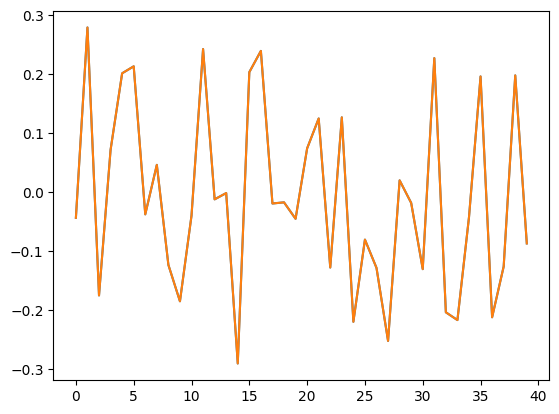

In [240]:
t = 0 # 100
_ = plt.plot( weights_nlgp[t][err[-1].argmin()] )
_ = plt.plot( weights_gauss[t][err[-1].argmin()] )

### Tracking peaks

In [122]:
argsort_nlgp = np.argsort(weights_nlgp, axis=-1)
argsort_gauss = np.argsort(weights_gauss, axis=-1)

def give_sort(ind):
    x = np.empty(40)
    x[ind] = np.arange(40)
    return x

indices_nlgp = np.apply_along_axis(give_sort, 2, argsort_nlgp)
indices_gauss = np.apply_along_axis(give_sort, 2, argsort_gauss)

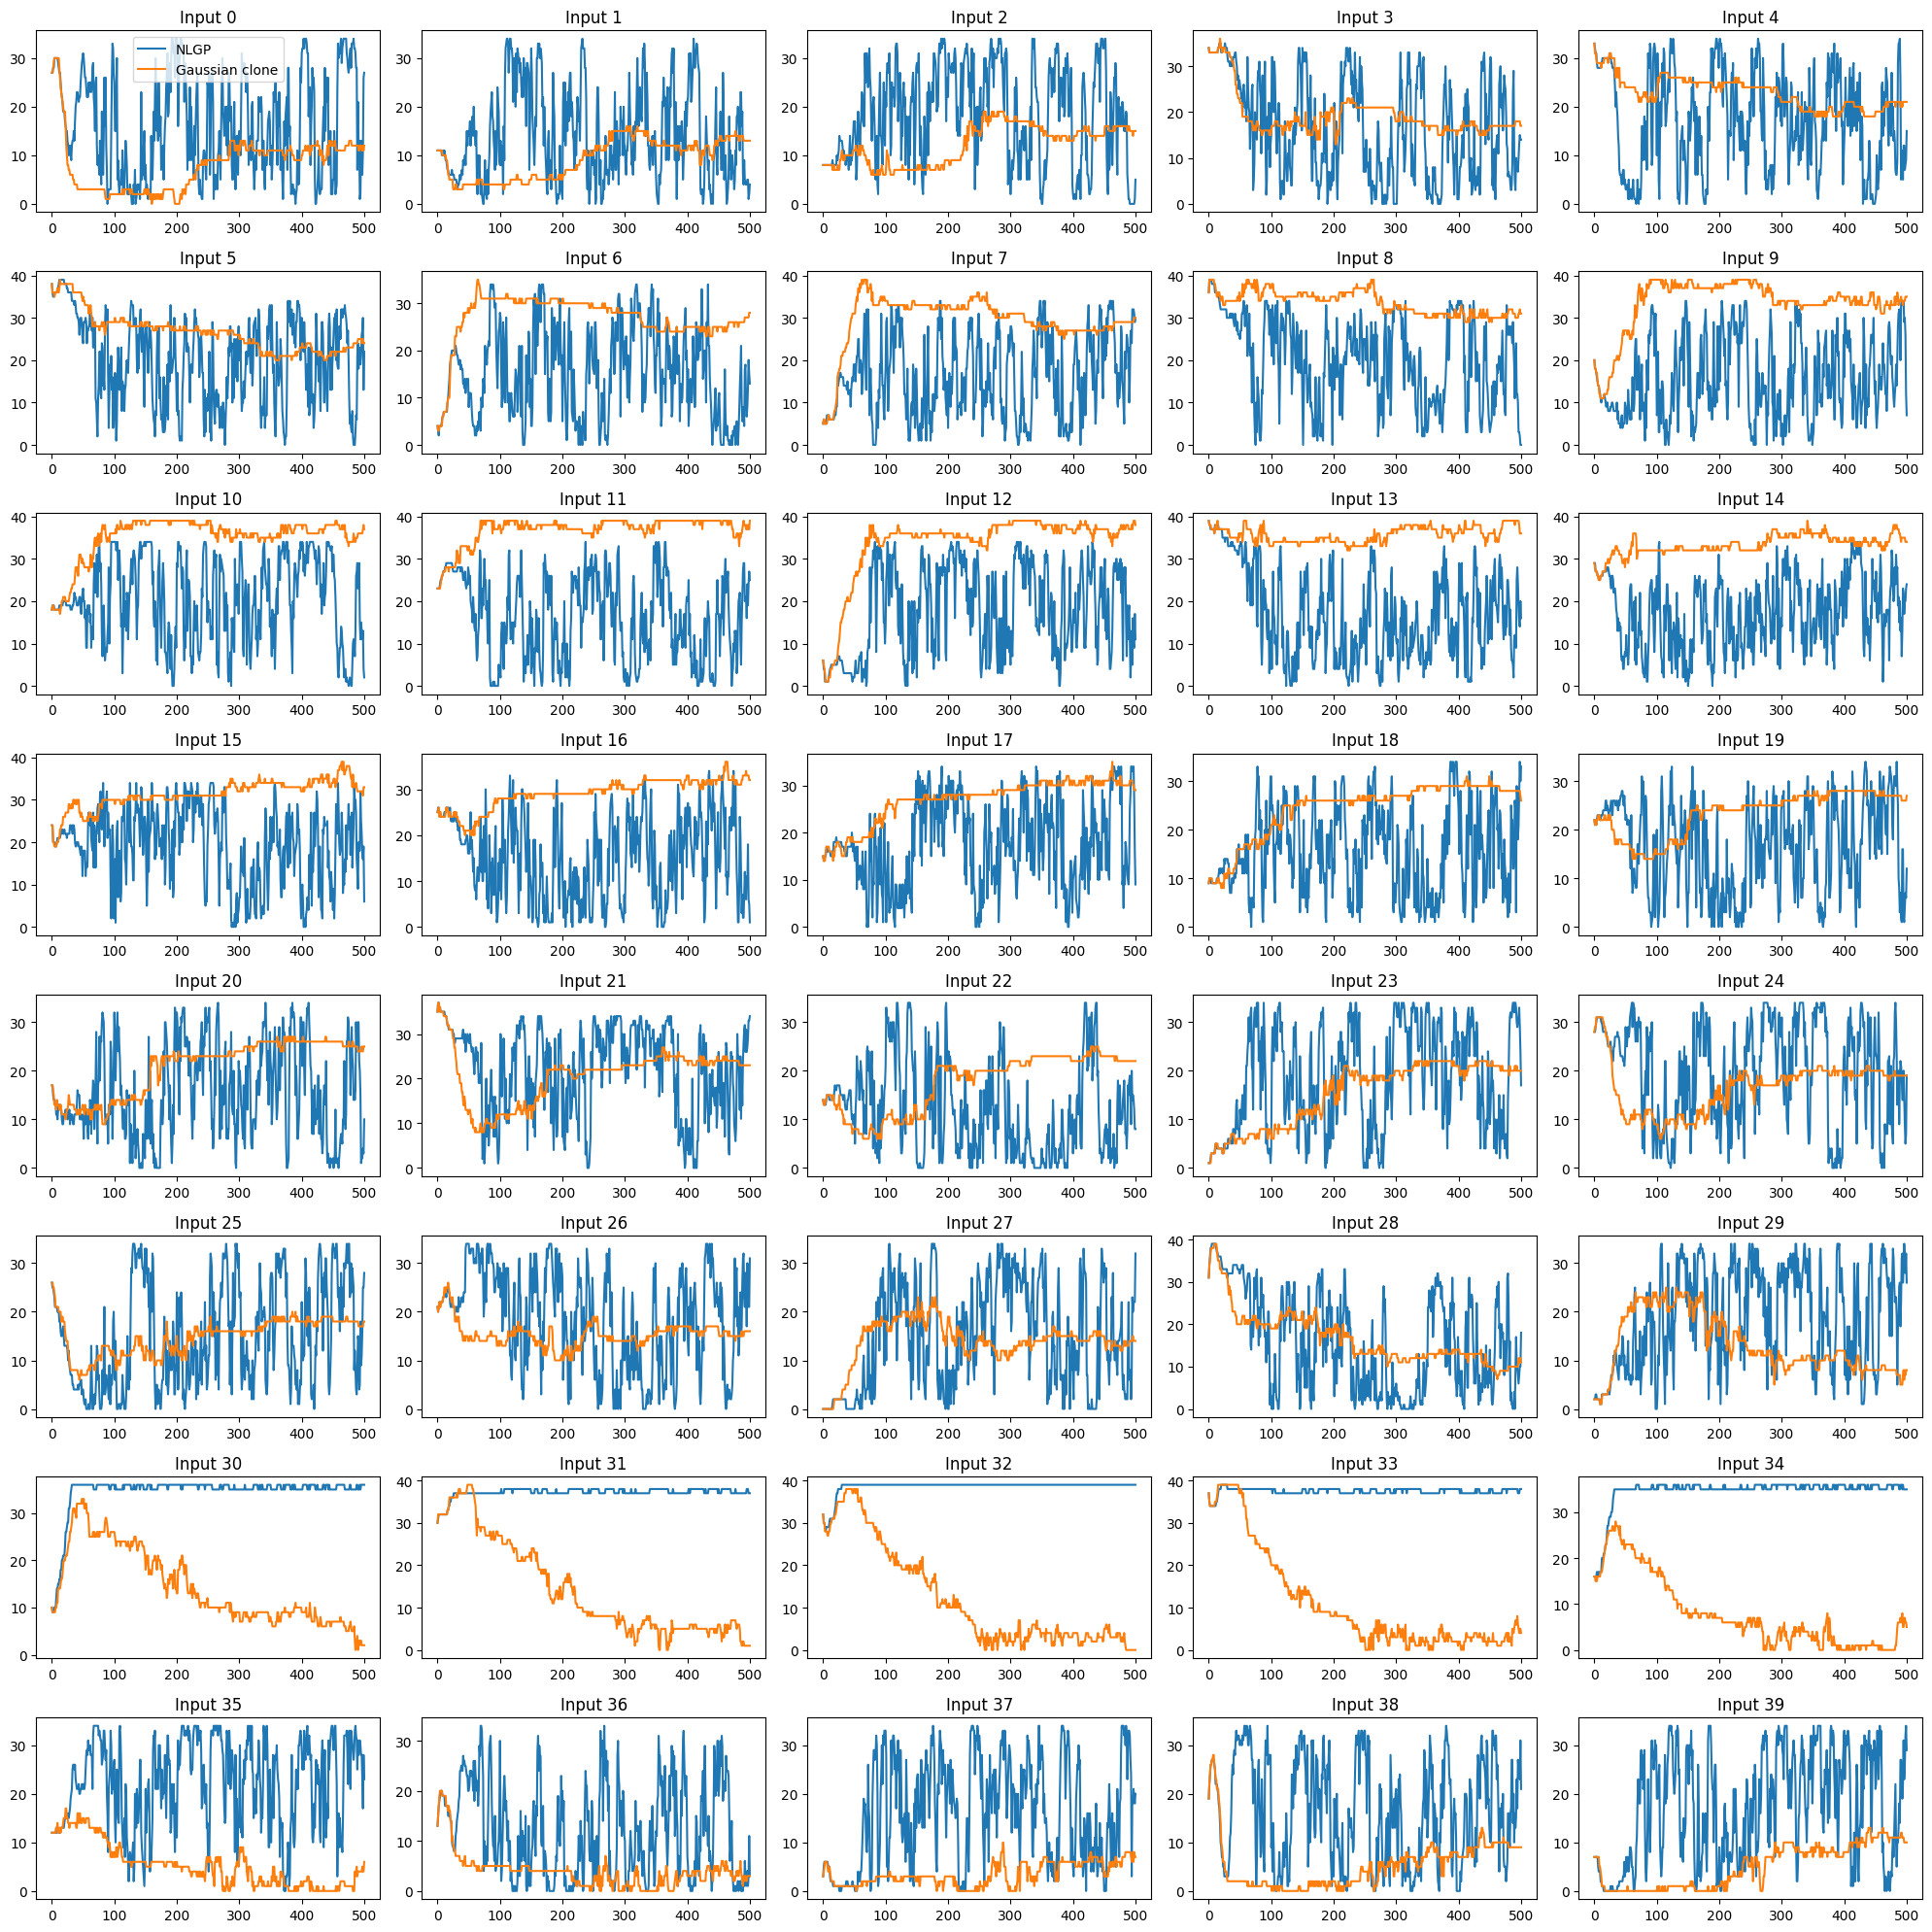

In [42]:
fig, axs = plt.subplots(8, 5, figsize=(20, 20))
for i, ax in enumerate(axs.flatten()):
    ax.plot(indices_nlgp[:,i], label='NLGP')
    ax.plot(indices_gauss[:,i], label='Gaussian clone')
    # ax.set_xscale('log')
    ax.set_title(f'Input {i}')
    if i == 0:
        ax.legend()
fig.tight_layout()

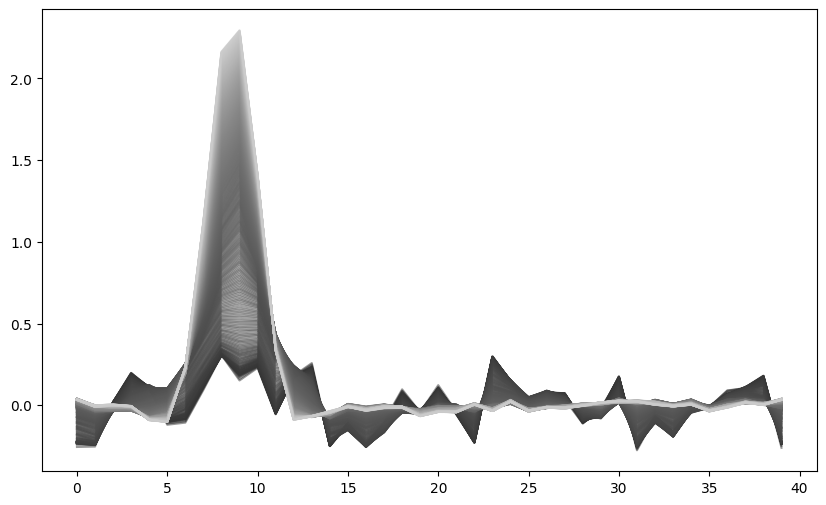

In [123]:
fig, axs = plot_rf_evolution(weights_nlgp[:,:1,:], num_cols=1, num_rows=1, figsize=(10, 6))

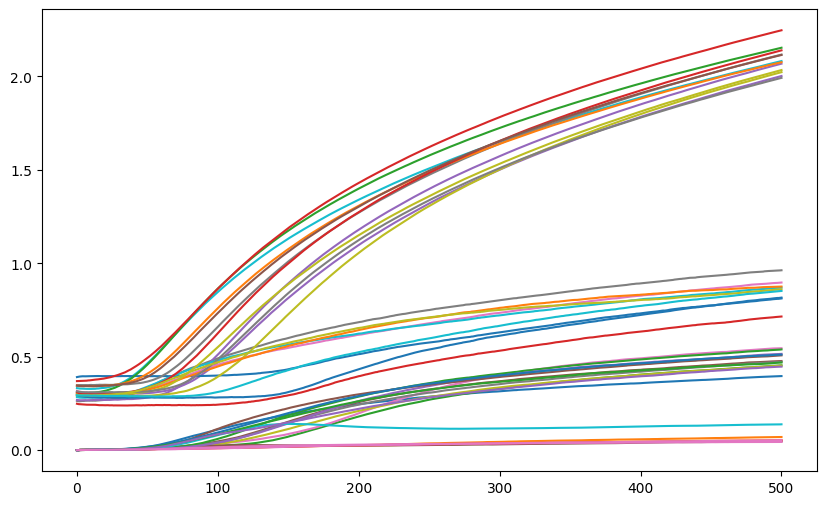

In [301]:
err = np.sqrt(np.mean(np.square(weights_nlgp - weights_gauss), axis=(2,)))
fig, ax = plt.subplots(figsize=(10, 6))
_ = ax.plot( err )

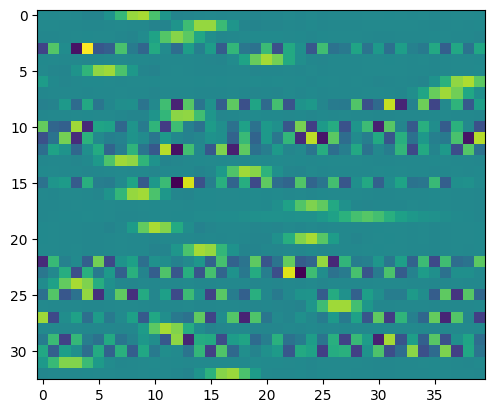

In [302]:
_ = plt.imshow( weights_nlgp[-1][ err[-1] > 0.2 ] )

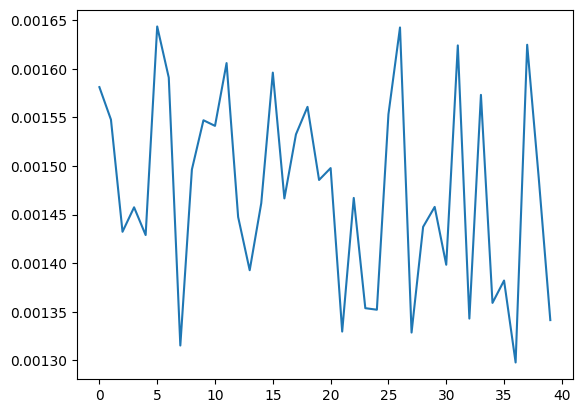

In [130]:
plt.plot( err[np.argmax(err[-1])] )

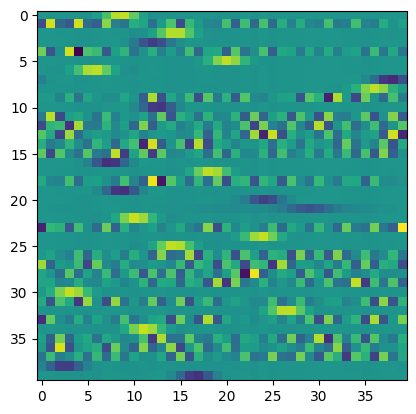

In [138]:
plt.imshow( weights_nlgp[-1] )

In [140]:
entropy(weights_nlgp[-1])

array([1.9404727 , 4.16531153, 1.9354753 , 1.84546184, 4.46531153,
       1.81331854, 1.89039795, 1.74046857, 1.61653864, 4.49643934,
       1.78907855, 4.53418372, 4.66531153, 4.48418372, 4.58418372,
       4.56531153, 1.84546184, 1.76953628, 4.53418372, 1.83907855,
       1.9715883 , 2.71758474, 1.9404727 , 4.77192809, 1.82838982,
       1.95832114, 4.61531153, 4.38418372, 4.31531153, 4.53418372,
       1.72535517, 4.35869497, 1.75771747, 4.44643934, 1.9404727 ,
       4.52192809, 4.46531153, 4.43418372, 1.60628485, 1.84546184])

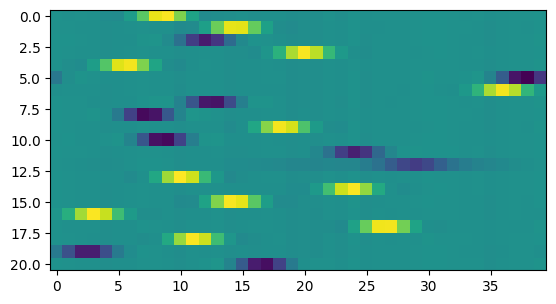

In [146]:
plt.imshow( weights_nlgp[-1][entropy(weights_nlgp[-1]) < 3] )

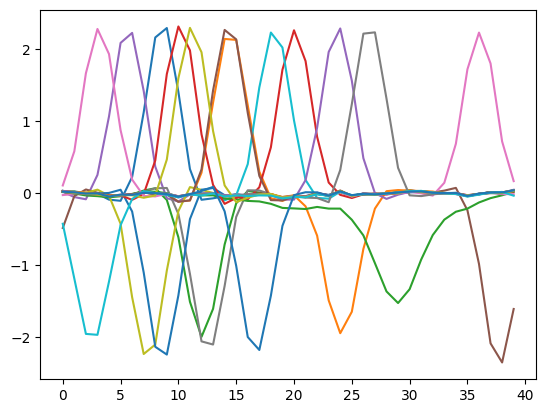

In [186]:
_ = plt.plot( weights_nlgp[-1][entropy(weights_nlgp[-1]) < 3].T )

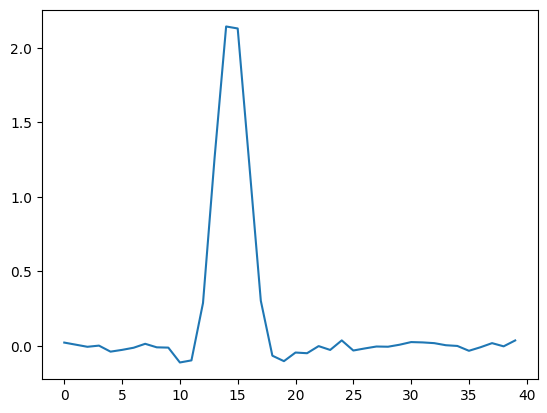

In [191]:
plt.plot( weights_nlgp[:, entropy(weights_nlgp[-1]) < 3, :][-1, 1, :] )

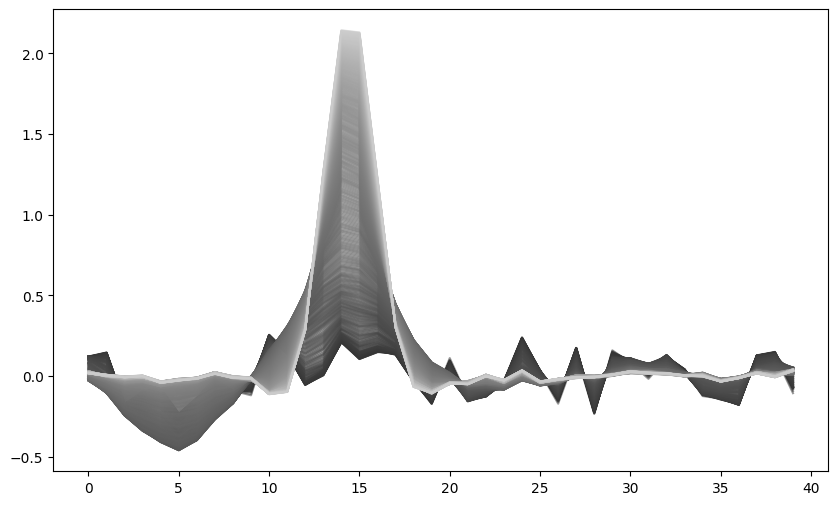

In [189]:
fig, axs = plot_rf_evolution(weights_nlgp[:, entropy(weights_nlgp[-1]) < 3, :][:, 1:2, :], num_cols=1, num_rows=1, figsize=(10, 6))

In [180]:
weights_nlgp[-1, entropy(weights_nlgp[-1]) < 3, :].max(axis=1) > -weights_nlgp[-1, entropy(weights_nlgp[-1]) < 3, :].min(axis=1)

array([ True,  True, False,  True,  True, False,  True, False, False,
        True, False, False, False,  True,  True,  True,  True,  True,
        True, False, False])

In [ ]:
weights_nlgp[-1, entropy(weights_nlgp[-1]) < 3, :].max(axis=1) > -weights_nlgp[-1, entropy(weights_nlgp[-1]) < 3, :].min(axis=1)

In [220]:
def track_top_n_overlap(argsort, n=5):
    num_steps, num_inputs = argsort.shape
    ind = slice(-n, None) if n > 0 else slice(None, -n)
    final_rank = argsort[-1,ind]
    return np.array([[ i in final_rank for i in argsort[t,ind] ] for t in range(num_steps)])

def track_top_n_single(argsort, n=5):
    num_steps, num_inputs = argsort.shape
    ind = slice(-n, None) if n > 0 else slice(None, n)
    final_rank = argsort[-1,-1] if n > 0 else argsort[-1,0]
    return np.array([ final_rank in argsort[t,ind] for t in range(num_steps)])

In [290]:
# I want to track the indices of the top n inputs
def get_top_n(weights, n=5):
    is_pos = weights[-1].max(axis=1) > -weights[-1].min(axis=1)
    weights *= (2 * is_pos - 1).reshape(1, -1, 1)
    argsort = np.argsort(weights, axis=-1)
    top_n = argsort[:, :, -n:]
    final_1 = argsort[-1, :, -1]
    return np.sum(top_n == final_1.reshape(1, -1, 1), axis=2)

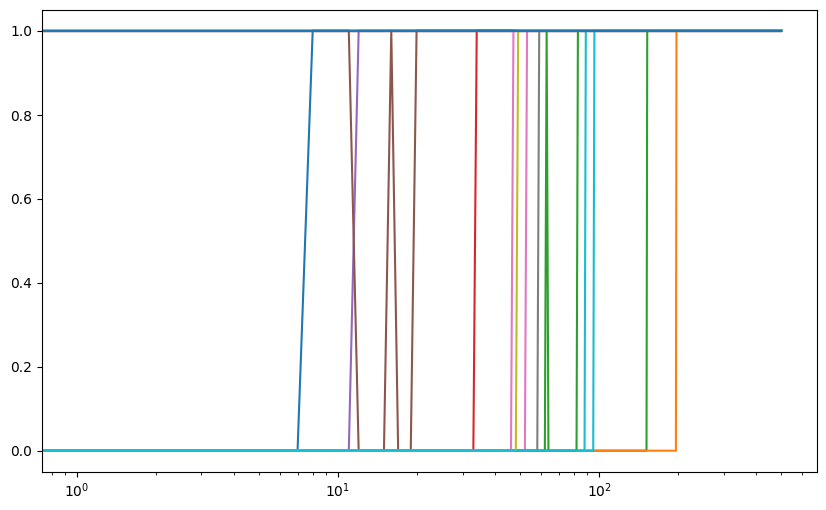

In [293]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot( get_top_n(weights_nlgp[:, entropy(weights_nlgp[-1]) < 3, :]) )
ax.set_xscale('log')

In [295]:
def give_sort(ind):
    x = np.empty(40)
    x[ind] = np.arange(40)
    return x

def track_weights(weights, n=5):
    # get ranking of positions for each neuron across time
    argsort = np.argsort(weights, axis=-1)
    
    # track consistency of top n positions across time
    is_pos = weights[-1].max(axis=1) > -weights[-1].min(axis=1)
    n_ = (2 * is_pos.astype(int) - 1) * n
    # for i, ni in enumerate(n_):
    #     print( track_top_n_overlap(indices[:,i,:], n=ni).shape )
    top_n_overlap_ = np.stack([ track_top_n_overlap(argsort[:,i,:], n=ni) for i, ni in enumerate(n_) ], axis=1)
    # print(top_n_overlap_.shape)
    # top_n_overlap = np.mean(top_n_overlap_, axis=2)
    top_n_single = np.stack([ track_top_n_single(argsort[:,i,:], n=ni) for i, ni in enumerate(n_) ], axis=1)
    
    return top_n_overlap_, top_n_single

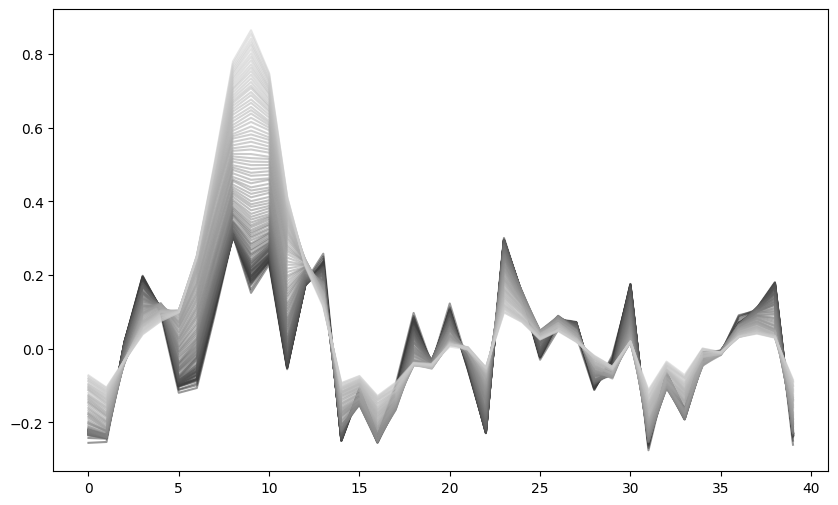

In [241]:
fig, axs = plot_rf_evolution(weights_nlgp[:100, :1, :], num_cols=1, num_rows=1, figsize=(10, 6))

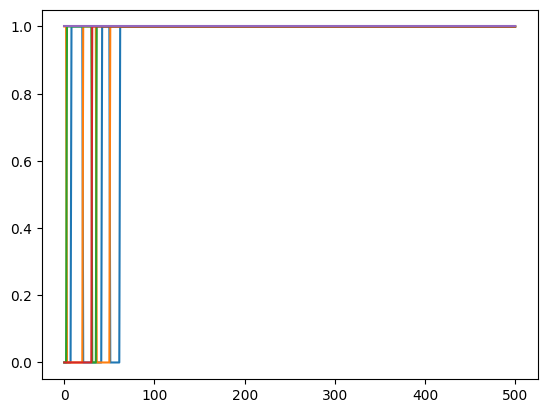

In [296]:
top_n_overlap, top_n_single = track_weights(weights_nlgp, n=5)
plt.plot( top_n_overlap[:, 0] ) # [:, entropy(weights_nlgp[-1]) < 3][:, 0] )

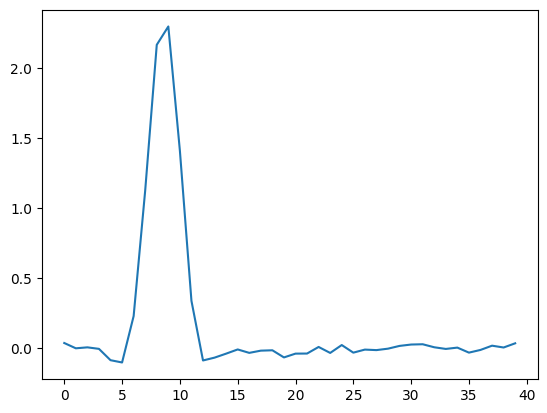

In [271]:
plt.plot( weights_nlgp[-1,0] )

In [270]:
indices_nlgp[-1,0]

array([33., 21., 24., 19.,  2.,  0., 34., 36., 38., 39., 37., 35.,  1.,
        3.,  5., 17.,  9., 12., 13.,  4.,  6.,  7., 26.,  8., 29., 10.,
       16., 14., 20., 27., 30., 31., 25., 18., 22., 11., 15., 28., 23.,
       32.])

In [272]:
argsort_nlgp[-1,0]

array([ 5, 12,  4, 13, 19, 14, 20, 21, 23, 16, 25, 35, 17, 18, 27, 36, 26,
       15, 33,  3, 28,  1, 34, 38,  2, 32, 22, 29, 37, 24, 30, 31, 39,  0,
        6, 11,  7, 10,  8,  9])

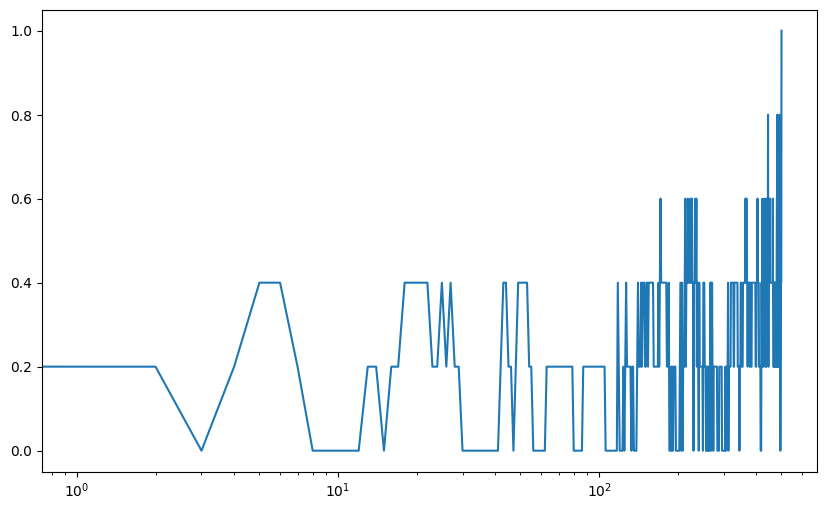

In [268]:
track = track_top_n_overlap(indices_nlgp[:, 0, :], n=5) # [:, entropy(weights_nlgp[-1]) < 3, :][:, 0, :]
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot( np.mean(track, axis=1) )
ax.set_xscale('log')

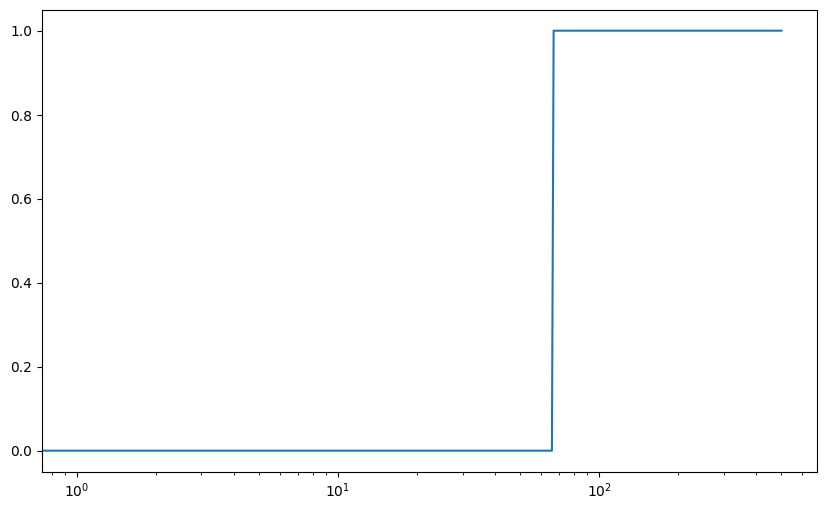

In [173]:
track = track_top_n_single(argsort_nlgp[:, entropy(weights_nlgp[-1]) < 3, :][:, 0, :], n=1)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot( track )
ax.set_xscale('log')

### What happens during the early period?

Numerically integrating the Gaussian ODE.

In [171]:
# discrete Fourier transform
n = config_['num_dimensions']
DFT = np.zeros((n, n), dtype=complex)
w = np.exp(-2 * np.pi * 1j / n)
for i in range(DFT.shape[0]):
    DFT[:, i] = w ** (i * np.arange(n))
DFT /= np.sqrt(n)

DCT = DFT.real
DST = DFT.imag

DRT_ = np.sqrt(2) * np.concatenate((DCT[:, :(n//2+1)], DST[:, 1:(n//2)]), axis=1)
DRT_[:,0] /= np.sqrt(2)
DRT_[:,n//2] /= np.sqrt(2)
DRT = np.zeros((n, n))
DRT[:,0] = DRT_[:,0]
DRT[:,1::2] = DRT_[:,1:n//2+1]
DRT[:,2::2] = DRT_[:,n//2+1:]

# check that it forms an orthonormal basis for R^n
print( np.linalg.norm(DRT.T @ DRT - np.eye(n)) )

1.397525836506499e-13


In [174]:
def Z(g):
    return jnp.sqrt( (2/jnp.pi) * jnp.arcsin( (2*g**2) / (1 + (2*g**2)) ) )

def build_non_gaussian_covariance(xi, L, g):
    C = jnp.abs(jnp.tile(jnp.arange(L)[:, jnp.newaxis], (1, L)) - jnp.tile(jnp.arange(L), (L, 1)))
    C = jnp.minimum(C, L - C)
    C = jnp.exp(-C ** 2 / (xi ** 2))
    Sigma = (2/jnp.pi) / (Z(g) ** 2) * jnp.arcsin( (2*g**2) / (1 + (2*g**2)) * C )
    return Sigma

Sigma1 = build_non_gaussian_covariance(config['xi1'], n, config['gain'])
Sigma0 = build_non_gaussian_covariance(config['xi2'], n, config['gain'])
Lambda1, Lambda0 = DRT.T @ Sigma1 @ DRT, DRT.T @ Sigma0 @ DRT
Lambda1, Lambda0 = np.diag(Lambda1), np.diag(Lambda0)

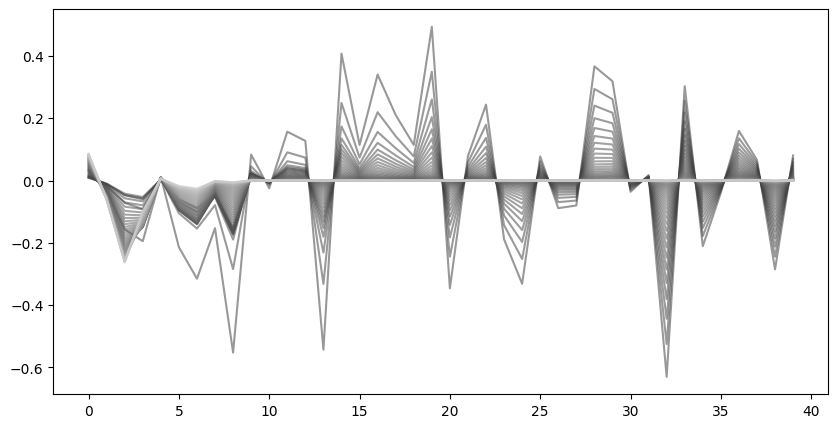

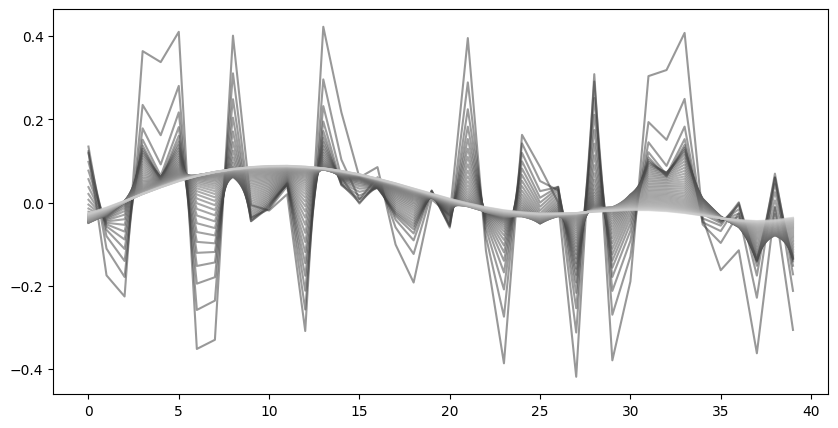

In [185]:
num_steps = config['num_epochs']
u1 = np.zeros((num_steps, n))
diag = np.zeros((num_steps, n))

u1[0] = DRT.T @ weights_gauss[0][0]
lr = config['learning_rate']
for t in range(1, num_steps):
    u1_ = u1[t-1]
    # norm_ = np.asarray(u1_.T @ Lambda1 @ u1_)[0][0]
    norm_ = ( u1_ * Lambda1 * u1_ ).sum()
    diag[t] = Lambda0 + ( 1 - np.sqrt(2/np.pi) * (1 / np.sqrt(norm_)) ) * Lambda1
    step = -0.25 * diag[t] * u1_
    u1[t] = 0.5 * lr * step + u1_
# in Fourier space
fig, axs = plot_rf_evolution(u1[::100].reshape(-1, 1, n), num_cols=1, num_rows=1, figsize=(10, 5))
# in real space
w1 = np.asarray(np.inner(u1, DRT))
fig, axs = plot_rf_evolution(w1[::100].reshape(-1, 1, n), num_cols=1, num_rows=1, figsize=(10, 5))
# fig.savefig('../thoughts/towards_gdln/figs/math/long_range_theory.png', dpi=300)

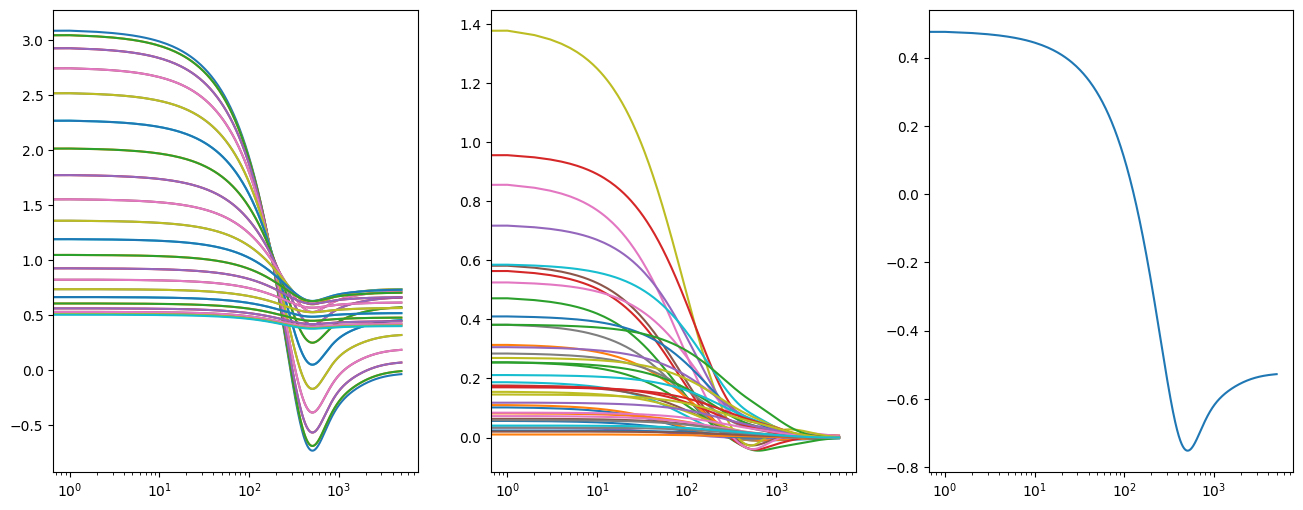

In [223]:
reg = 1 - np.sqrt(2/np.pi) / np.sqrt(((u1 ** 2) * Lambda1).sum(axis=1))
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].plot( diag )
axs[0].set_xscale('log')
axs[1].plot( diag * np.abs(u1) )
axs[1].set_xscale('log')
axs[2].plot( reg )
axs[2].set_xscale('log')

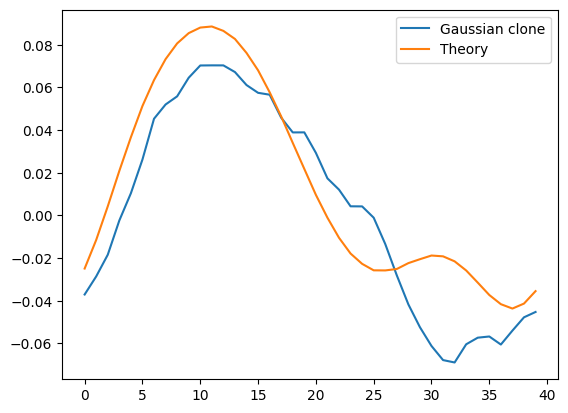

In [186]:
_ = plt.plot( weights_gauss[-1][0], label='Gaussian clone')
_ = plt.plot( w1[-1], label='Theory')
plt.legend()

## Comparable randomness

#### Quickly define DRT

In [2]:
# discrete Fourier transform
n = config_['num_dimensions']
DFT = jnp.zeros((n, n), dtype=complex)
w = np.exp(-2 * jnp.pi * 1j / n)
for i in range(DFT.shape[0]):
    # DFT[:, i] = w ** (i * jnp.arange(n))
    DFT = DFT.at[:,i].set(w ** (i * jnp.arange(n)) / jnp.sqrt(n))

DCT = DFT.real
DST = DFT.imag

DRT_ = jnp.sqrt(2) * jnp.concatenate((DCT[:, :(n//2+1)], DST[:, 1:(n//2)]), axis=1)
DRT_ = DRT_.at[:,0].set(DRT_[:,0] / jnp.sqrt(2))
DRT_ = DRT_.at[:,n//2].set(DRT_[:,n//2] / jnp.sqrt(2))
DRT = jnp.zeros((n, n))
DRT = DRT.at[:,0].set(DRT_[:,0])
DRT = DRT.at[:,1::2].set(DRT_[:,1:n//2+1])
DRT = DRT.at[:,2::2].set(DRT_[:,n//2+1:])

# check that it forms an orthonormal basis for R^n
print( jnp.linalg.norm(DRT.T @ DRT - jnp.eye(n)) )

1.1333754e-05


In [ ]:
# high gain
config = config_.copy()
config.update(dict(
    num_hiddens=40, learning_rate=5., num_epochs=5000, gain=3,
    batch_size=1000, evaluation_interval=500,
))

weights, metrics = simulate_or_load(**config)
fig, axs = plot_receptive_fields(weights[::5], num_cols=11, evaluation_interval=500, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

#### How are we drawing samples?

We want to make our comparison between the non-Gaussian case and the Gaussian clone as fair as possible.
Jax lets us control our randomness, so we're going to make sure that _individual draws_ are nearly identical, not just their distributions up to the second moment.

The code blocks below show some tweaks I made to the data generating functions.
The original script now actually uses these functions.
I left the old ones in there with the suffix `_old` for reproducibility.

In [93]:
from jax.scipy.special import erf as gain_function

def Z(g):
    return jnp.sqrt( (2/jnp.pi) * jnp.arcsin( (2*g**2) / (1 + (2*g**2)) ) )

def generate_non_gaussian(key, xi, L, g):
    C = jnp.abs(jnp.tile(jnp.arange(L)[:, jnp.newaxis], (1, L)) - jnp.tile(jnp.arange(L), (L, 1)))
    C = jnp.minimum(C, L - C)
    C = jnp.exp(-C ** 2 / (xi ** 2))
    evals = jnp.diag(DRT.T @ C @ DRT)
    sqrt_C = DRT @ jnp.diag(jnp.sqrt(evals)) @ DRT.T
    
    z_id = jax.random.normal(key, (L,))
    z = sqrt_C @ z_id
    x = gain_function(g * z) / Z(g)
    return x

def generate_gaussian(key, xi, L, g):
    C = jnp.abs(jnp.tile(jnp.arange(L)[:, jnp.newaxis], (1, L)) - jnp.tile(jnp.arange(L), (L, 1)))
    C = jnp.minimum(C, L - C)
    C = jnp.exp(-C ** 2 / (xi ** 2))
    Sigma = (2/jnp.pi) / (Z(g) ** 2) * jnp.arcsin( (2*g**2) / (1 + (2*g**2)) * C )
    evals = jnp.diag(DRT.T @ Sigma @ DRT)
    sqrt_Sigma = DRT @ jnp.diag(jnp.sqrt(evals)) @ DRT.T
    
    z_id = jax.random.normal(key, (L,))
    x = sqrt_Sigma @ z_id
    return x

In [94]:
x_nlgp = generate_non_gaussian(jax.random.PRNGKey(0), 2, 40, 0.01)
x_gauss = generate_gaussian(jax.random.PRNGKey(0), 2, 40, 0.01)

In [95]:
x_nlgp

Array([-0.68709075, -0.7193196 ,  0.34922612,  0.9019674 ,  0.7446145 ,
        0.31895846, -0.07796379,  0.2238579 , -0.06826366, -1.0513674 ,
       -1.4014025 , -1.0894202 ,  0.0882518 ,  1.1463132 ,  1.4553694 ,
        1.4798611 ,  0.35250574, -0.842366  , -0.8566427 , -0.21768367,
        0.2102705 ,  0.15346704, -0.15815584, -0.5076198 , -0.92550874,
       -1.0346748 , -0.69094175, -0.21261801,  0.09134713,  0.63096577,
        1.4742882 ,  2.3633375 ,  3.086115  ,  2.945898  ,  1.458956  ,
       -0.5649974 , -1.5556636 , -1.0465302 , -0.25442892, -0.17908867],      dtype=float32)

In [96]:
x_gauss

Array([-0.687033  , -0.71926016,  0.3491927 ,  0.90190184,  0.7445539 ,
        0.3189277 , -0.07795602,  0.22383592, -0.06825686, -1.0513011 ,
       -1.4013542 , -1.0893545 ,  0.08824301,  1.146249  ,  1.4553267 ,
        1.4798214 ,  0.35247195, -0.8423017 , -0.8565782 , -0.21766226,
        0.21024981,  0.15345185, -0.15814018, -0.5075734 , -0.9254427 ,
       -1.0346084 , -0.69088376, -0.2125971 ,  0.09133805,  0.6309111 ,
        1.4742477 ,  2.3635416 ,  3.0867867 ,  2.9464567 ,  1.4589138 ,
       -0.56494695, -1.5556338 , -1.0464638 , -0.25440407, -0.17907098],      dtype=float32)

This is exactly what we want.
We confirm this for the high-gain case by looking at the signs & scales.

#### After making the changes...

In [31]:
nlgp_dataset = datasets.NonlinearGPDataset(key=jax.random.PRNGKey(0), **config_, gain=3, num_exemplars=10000)
gauss_dataset = datasets.NLGPGaussianCloneDataset(key=jax.random.PRNGKey(0), **config_, gain=3, num_exemplars=10000)

In [32]:
x_nlgp, y_nlgp = nlgp_dataset[:10000]
x_gauss, y_gauss = nlgp_dataset[:10000]

In [8]:
# sanity check
print( np.mean(y_nlgp == y_gauss) )

1.0


In [12]:
# low-gain, should be identical
print( jnp.mean(jnp.square(x_nlgp - x_gauss)) )

0.0


In [15]:
# high-gain, signs should agree
print( jnp.mean(jnp.sign(x_nlgp) == jnp.sign(x_gauss)) )

1.0


In [48]:
t = -1
# nlgp model on nlgp data
print( ((jax.nn.relu( weights_nlgp[t] @ x_nlgp.T ).mean(axis=0) > 0.5) == y_nlgp).mean(), ((jax.nn.relu( weights_nlgp[t] @ x_nlgp.T ).mean(axis=0) - y_nlgp) ** 2).mean() )
# nglp model on gaussian clone data
print( ((jax.nn.relu( weights_nlgp[t] @ x_gauss.T ).mean(axis=0) > 0.5) == y_gauss).mean(), ((jax.nn.relu( weights_nlgp[t] @ x_gauss.T ).mean(axis=0) - y_gauss) ** 2).mean() )
# gaussian model on nlgp data
print( ((jax.nn.relu( weights_gauss[t] @ x_nlgp.T ).mean(axis=0) > 0.5) == y_nlgp).mean(), ((jax.nn.relu( weights_gauss[t] @ x_nlgp.T ).mean(axis=0) - y_nlgp) ** 2).mean() )
# gaussian model on gaussian clone data
print( ((jax.nn.relu( weights_gauss[t] @ x_gauss.T ).mean(axis=0) > 0.5) == y_gauss).mean(), ((jax.nn.relu( weights_gauss[t] @ x_gauss.T ).mean(axis=0) - y_gauss) ** 2).mean() )

0.7782 0.18458657
0.7782 0.18458657
0.7723 0.1886713
0.7723 0.1886713
